# Time Series Forecasting con Transformers de Hugging Face
# Dataset: Precio de Bitcoin en USD (BTC-USD)

In [8]:
!pip install darts --quiet

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse, mape
from darts.models import TransformerModel, NHiTSModel, TFTModel
import random
import torch
import time

In [10]:
# Descargar y descomprimir el dataset desde Kaggle usando curl directo
zip_path = "bitcoin-historical-data.zip"
csv_filename = "btcusd_1-min_data.csv"

if not os.path.exists(csv_filename):
    if not os.path.exists(zip_path):
        !curl -L -o bitcoin-historical-data.zip \
            https://www.kaggle.com/api/v1/datasets/download/mczielinski/bitcoin-historical-data
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

In [23]:
# Funciones auxiliares
def count_model_parameters(darts_model):
    """Cuenta los parámetros entrenables de un modelo Darts basado en PyTorch."""
    try:
        # La mayoría de los modelos Darts basados en PyTorch exponen el modelo subyacente en '.model'
        if hasattr(darts_model, 'model') and hasattr(darts_model.model, 'parameters'):
             return sum(p.numel() for p in darts_model.model.parameters() if p.requires_grad)
        elif hasattr(darts_model, '_model') and hasattr(darts_model._model, 'parameters'):
             return sum(p.numel() for p in darts_model._model.parameters() if p.requires_grad)
        else:
            print(f"Advertencia: No se pudo acceder a los parámetros para {type(darts_model)}. Verifique la estructura interna del modelo. Se devolverá 0.")
            return 0
    except Exception as e:
        print(f"Error al contar parámetros para {type(darts_model)}: {e}. Se devolverá 0.")
        return 0

# Cálculo de métricas
def calc_metrics(pred):
    return {
        'MAE': mae(test, pred),
        'MAPE': mape(test, pred),
        'RMSE': rmse(test, pred)
    }

# Función para crear y mostrar un gráfico de barras agrupadas para una métrica
def plot_custom_barchart(df, value_columns, value_short_names, title, y_label, lower_is_better=True, value_format=".4f"):
    """
    Crea un gráfico de barras agrupadas para un conjunto personalizado de columnas.

    Args:
        df (pd.DataFrame): DataFrame con los resultados.
        value_columns (list): Lista de nombres de columnas del df que contienen los valores a graficar.
        value_short_names (list): Lista de nombres cortos para la leyenda (debe coincidir con value_columns).
        title (str): Título del gráfico.
        y_label (str): Etiqueta para el eje Y.
        lower_is_better (bool): True si valores más bajos son mejores (para métricas de error).
                                False si valores más altos son mejores (ej. para precisión).
        value_format (str): Formato para las anotaciones numéricas en las barras.
    """
    if len(value_columns) != len(value_short_names):
        raise ValueError("value_columns y value_short_names deben tener la misma longitud.")

    # Crear un DataFrame temporal para el gráfico
    plot_df = df[['Ventana'] + value_columns].copy()
    plot_df.columns = ['Ventana'] + value_short_names

    plot_df.set_index('Ventana', inplace=True)

    # Determinar el colormap basado en si menor es mejor o no
    cmap_choice = 'viridis_r' if lower_is_better else 'viridis'

    ax = plot_df.plot(kind='bar', figsize=(12, 7), colormap=cmap_choice)

    plt.title(title, fontsize=16, pad=20)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel('Configuración de Ventana de Entrenamiento', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Modelo')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Añadir etiquetas de valor encima de las barras
    for p in ax.patches:
        ax.annotate(format(p.get_height(), value_format),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=8)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics      


Entrenando con ventana de 1_año (365 días)

Entrenando modelos con ventana 1_año...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 248 K  | train
-------------------------------------------------------------
240 K     Traina

Transformer entrenado en: 38.28s, Parámetros: 549,386


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork     

NHiTS entrenado en: 16.17s, Parámetros: 240,818


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TFT entrenado en: 45.09s, Parámetros: 279,727


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

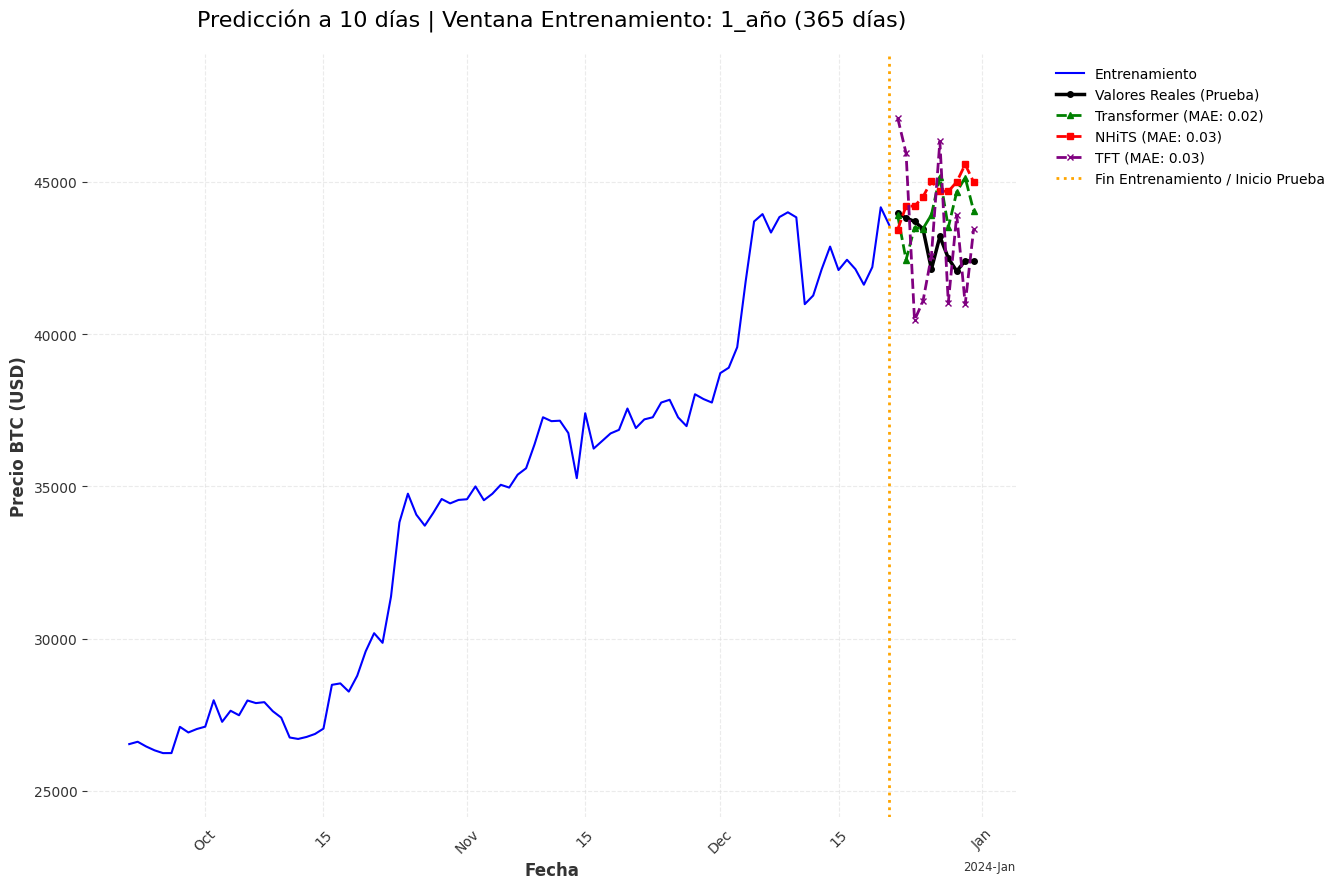

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics      


Entrenando con ventana de 6_meses (180 días)

Entrenando modelos con ventana 6_meses...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 248 K  | train
-------------------------------------------------------------
240 K     Traina

Transformer entrenado en: 15.2s, Parámetros: 549,386


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork     

NHiTS entrenado en: 7.35s, Parámetros: 240,818


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TFT entrenado en: 18.13s, Parámetros: 279,727


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

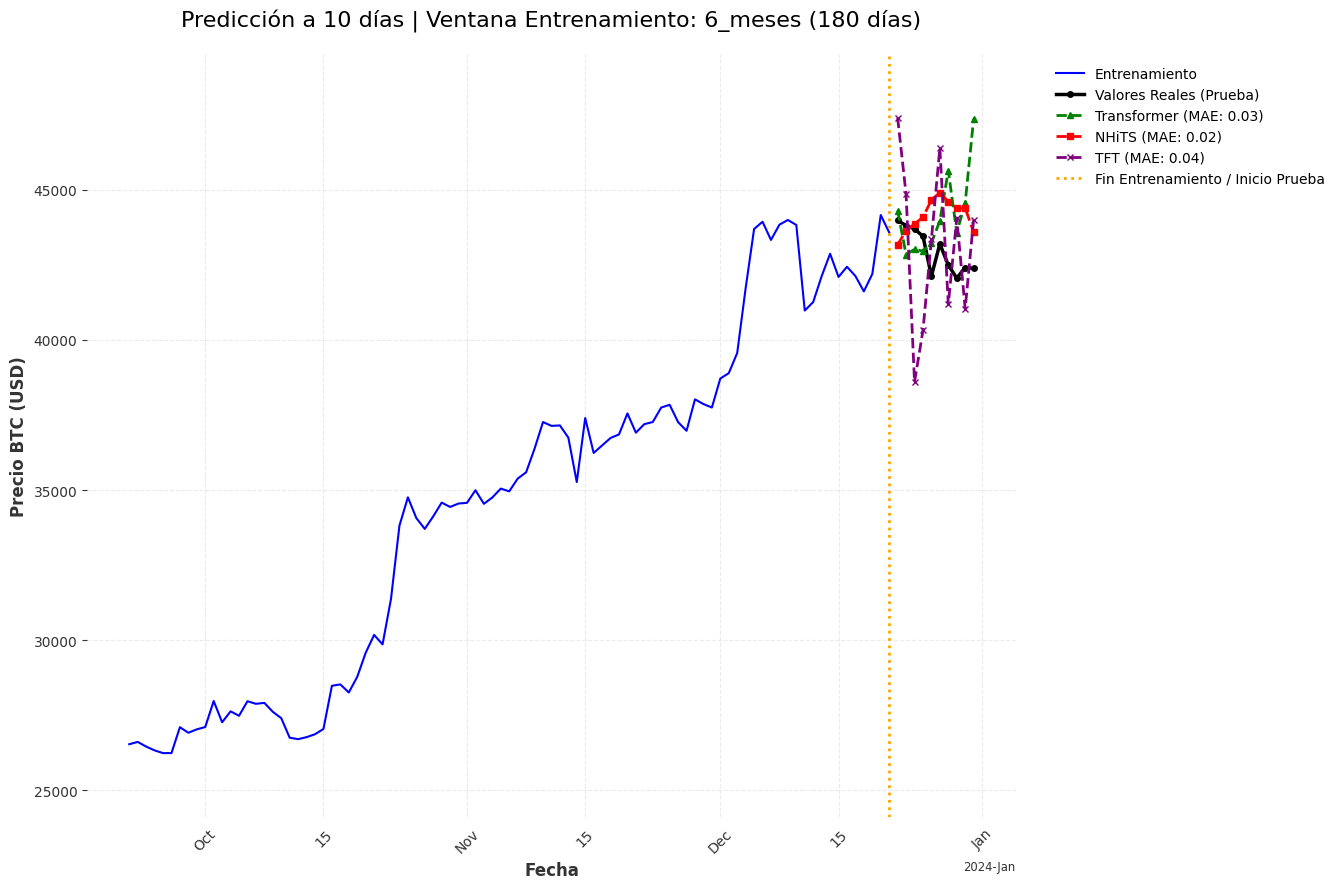

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics      


Entrenando con ventana de 3_meses (90 días)

Entrenando modelos con ventana 3_meses...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 227 K  | train
-------------------------------------------------------------
223 K     Traina

Transformer entrenado en: 8.23s, Parámetros: 549,386


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork     

NHiTS entrenado en: 4.53s, Parámetros: 223,338


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TFT entrenado en: 9.92s, Parámetros: 279,727


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

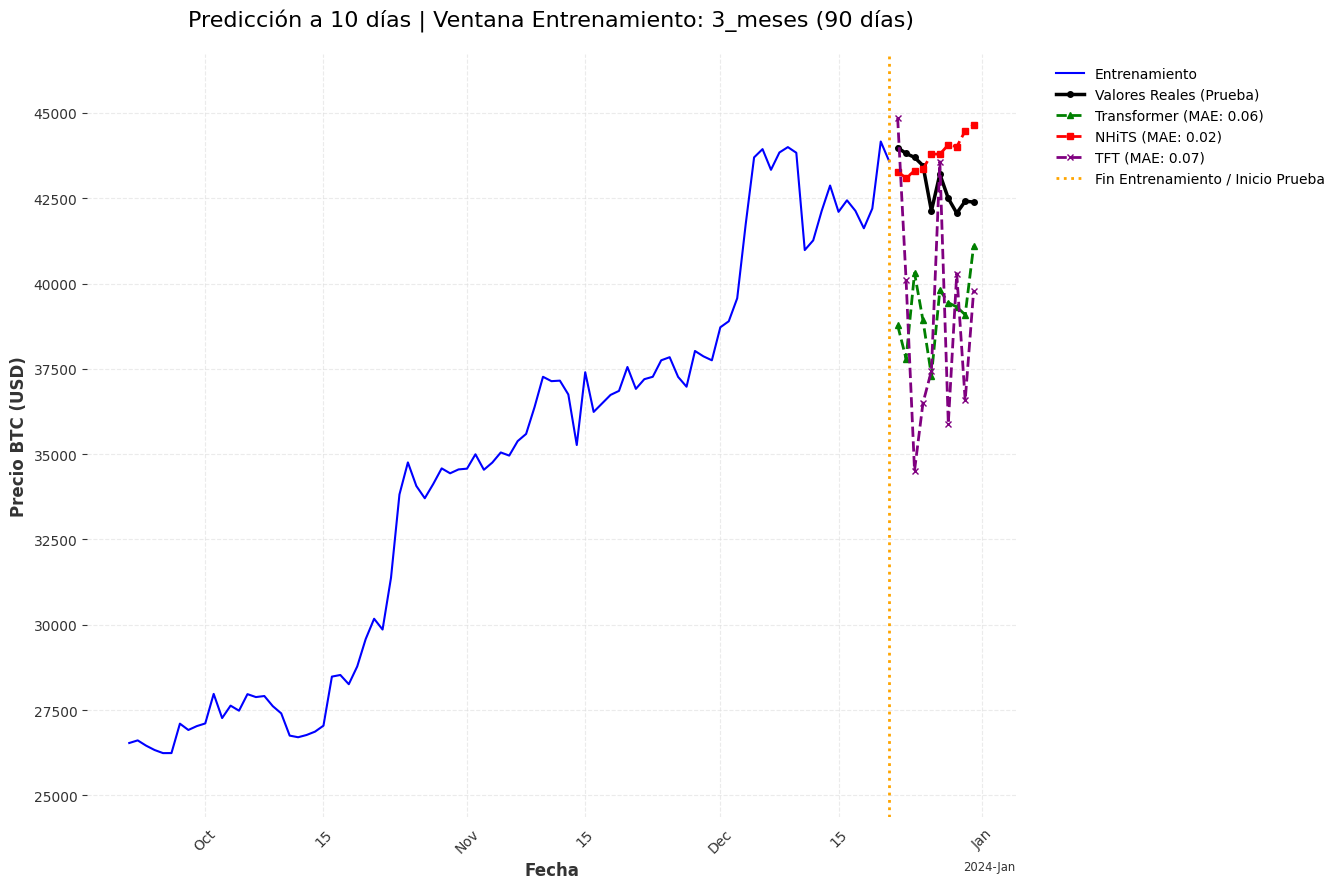


Resultados Comparativos:
| Ventana   |   Días |   Transformer_MAE |   Transformer_MAPE |   Transformer_RMSE |   Transformer_TrainTime_s |   Transformer_Params |   NHiTS_MAE |   NHiTS_MAPE |   NHiTS_RMSE |   NHiTS_TrainTime_s |   NHiTS_Params |   TFT_MAE |   TFT_MAPE |   TFT_RMSE |   TFT_TrainTime_s |   TFT_Params |
|:----------|-------:|------------------:|-------------------:|-------------------:|--------------------------:|---------------------:|------------:|-------------:|-------------:|--------------------:|---------------:|----------:|-----------:|-----------:|------------------:|-------------:|
| 1_año     |    365 |            0.0213 |             3.5618 |             0.0261 |                     38.28 |               549386 |      0.0283 |       4.7246 |       0.0328 |               16.17 |         240818 |    0.0322 |     5.2869 |     0.0353 |             45.09 |       279727 |
| 6_meses   |    180 |            0.0257 |             4.2868 |             0.0339 |              

In [25]:
# Establecer todas las semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Fechas fijas para el análisis
START_DATE = '2020-01-01'
END_DATE = '2023-12-31'
PREDICTION_HORIZON = 10  # 10 días hacia adelante

# Cargar y preparar datos
df = pd.read_csv("btcusd_1-min_data.csv")
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.rename(columns={'Close': 'price'})
df = df[['date', 'price']].dropna()
df = df[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]
df_daily = df.set_index('date').resample('D').last().ffill()

# Convertir a serie temporal
series = TimeSeries.from_dataframe(df_daily.reset_index(), 'date', 'price')
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_unscaled = scaler.inverse_transform(series_scaled)

# Configuraciones de ventanas históricas a probar
WINDOW_CONFIGS = {
    '1_año': 365,
    '6_meses': 180,
    '3_meses': 90,
}

results = []

for config_name, window_size in WINDOW_CONFIGS.items():
    print(f"\n{'='*50}")
    print(f"Entrenando con ventana de {config_name} ({window_size} días)")
    print(f"{'='*50}")

    # Definir períodos de entrenamiento y prueba
    train_end = series.time_index[-PREDICTION_HORIZON-1]
    train_start = train_end - pd.Timedelta(days=window_size)
    test_start = train_end + pd.Timedelta(days=1)
    test_end = test_start + pd.Timedelta(days=PREDICTION_HORIZON-1)

    # Crear subseries
    train = series_scaled.slice(train_start, train_end)
    test = series_scaled.slice(test_start, test_end)

    # Configuración común de modelos
    common_args = {
        'input_chunk_length': min(60, window_size//3),
        'output_chunk_length': PREDICTION_HORIZON,
        'random_state': SEED,
        'n_epochs': 100,
        'batch_size': 32,
        'optimizer_kwargs': {'lr': 1e-3},
        'model_name': f'{config_name}_model'
    }

    # Inicializar modelos
    transformer = TransformerModel(
        **common_args,
        d_model=64,
        nhead=4,
        num_encoder_layers=3,
        num_decoder_layers=3,
        dropout=0.1
    )

    nhits = NHiTSModel(
        **common_args,
        num_blocks=2,
        num_layers=3,
        layer_widths=128,
        dropout=0.1
    )

    tft = TFTModel(
        **common_args,
        hidden_size=64,
        lstm_layers=2,
        dropout=0.1,
        add_relative_index=True
    )

    # Entrenamiento y medición de tiempo
    print(f"\nEntrenando modelos con ventana {config_name}...")

    start_time_trans = time.time()
    transformer.fit(train, verbose=True)
    end_time_trans = time.time()
    train_time_trans = round(end_time_trans - start_time_trans, 2)
    params_trans = count_model_parameters(transformer)
    print(f"Transformer entrenado en: {train_time_trans}s, Parámetros: {params_trans:,}")

    start_time_nhits = time.time()
    nhits.fit(train, verbose=True)
    end_time_nhits = time.time()
    train_time_nhits = round(end_time_nhits - start_time_nhits, 2)
    params_nhits = count_model_parameters(nhits)
    print(f"NHiTS entrenado en: {train_time_nhits}s, Parámetros: {params_nhits:,}")

    start_time_tft = time.time()
    tft.fit(train, verbose=True)
    end_time_tft = time.time()
    train_time_tft = round(end_time_tft - start_time_tft, 2)
    params_tft = count_model_parameters(tft)
    print(f"TFT entrenado en: {train_time_tft}s, Parámetros: {params_tft:,}")

    # Predicción
    pred_trans = transformer.predict(n=PREDICTION_HORIZON)
    pred_nhits = nhits.predict(n=PREDICTION_HORIZON)
    pred_tft = tft.predict(n=PREDICTION_HORIZON)

    metrics_trans = calc_metrics(pred_trans)
    metrics_nhits = calc_metrics(pred_nhits)
    metrics_tft = calc_metrics(pred_tft)

    # Almacenar resultados
    results.append({
        'Ventana': config_name,
        'Días': window_size,
        'Transformer_MAE': round(metrics_trans['MAE'], 4),
        'Transformer_MAPE': round(metrics_trans['MAPE'], 4),
        'Transformer_RMSE': round(metrics_trans['RMSE'], 4),
        'Transformer_TrainTime_s': train_time_trans,
        'Transformer_Params': params_trans,
        'NHiTS_MAE': round(metrics_nhits['MAE'], 4),
        'NHiTS_MAPE': round(metrics_nhits['MAPE'], 4),
        'NHiTS_RMSE': round(metrics_nhits['RMSE'], 4),
        'NHiTS_TrainTime_s': train_time_nhits,
        'NHiTS_Params': params_nhits,
        'TFT_MAE': round(metrics_tft['MAE'], 4),
        'TFT_MAPE': round(metrics_tft['MAPE'], 4),
        'TFT_RMSE': round(metrics_tft['RMSE'], 4),
        'TFT_TrainTime_s': train_time_tft,
        'TFT_Params': params_tft,
    })

    # Preparar datos para visualización
    test_unscaled = scaler.inverse_transform(test)
    pred_trans_unscaled = scaler.inverse_transform(pred_trans)
    pred_nhits_unscaled = scaler.inverse_transform(pred_nhits)
    pred_tft_unscaled = scaler.inverse_transform(pred_tft)

    # Visualización
    plt.figure(figsize=(16, 9)) # Ligeramente más grande para mejor visualización

    # 1. Definir un contexto de días para mostrar antes de la predicción
    context_days_before_prediction = 90 # Mostrar los últimos 90 días de entrenamiento

    # Calcular el inicio del tramo de entrenamiento a graficar
    plot_train_start_date = train_end - pd.Timedelta(days=context_days_before_prediction)
    # Asegurarse de no ir más allá del inicio de la serie completa
    plot_train_start_date = max(plot_train_start_date, series_unscaled.start_time())

    # Graficar datos históricos de entrenamiento (solo el contexto definido)
    training_plot_slice = series_unscaled.slice(plot_train_start_date, train_end)
    training_plot_slice.plot(label=f'Entrenamiento', color='blue', linewidth=1.5)

    # 2. Graficar valores reales del período de prueba
    test_unscaled.plot(label='Valores Reales (Prueba)', color='black', linewidth=2.5, marker='o', markersize=4)

    # 3. Graficar predicciones
    pred_trans_unscaled.plot(
        label=f'Transformer (MAE: {metrics_trans["MAE"]:.2f})',
        color='green',
        linestyle='--',
        linewidth=2, marker='^', markersize=4)

    pred_nhits_unscaled.plot(
        label=f'NHiTS (MAE: {metrics_nhits["MAE"]:.2f})',
        color='red',
        linestyle='--',
        linewidth=2, marker='s', markersize=4)

    pred_tft_unscaled.plot(
        label=f'TFT (MAE: {metrics_tft["MAE"]:.2f})',
        color='purple',
        linestyle='--',
        linewidth=2, marker='x', markersize=4)

    # 4. Línea vertical para marcar fin de entrenamiento / inicio de prueba
    plt.axvline(x=train_end, color='orange', linestyle=':', linewidth=2,
               label='Fin Entrenamiento / Inicio Prueba')

    # 5. Ajustar límites del eje Y para enfocarse en el área de predicción
    # Recopilar todos los datos que se están mostrando en el período de interés
    data_for_ylim_calc = []
    data_for_ylim_calc.extend(training_plot_slice.values().flatten())
    data_for_ylim_calc.extend(test_unscaled.values().flatten())
    data_for_ylim_calc.extend(pred_trans_unscaled.values().flatten())
    data_for_ylim_calc.extend(pred_nhits_unscaled.values().flatten())
    data_for_ylim_calc.extend(pred_tft_unscaled.values().flatten())

    min_val = np.min(data_for_ylim_calc)
    max_val = np.max(data_for_ylim_calc)
    padding = (max_val - min_val) * 0.10  # 10% de padding

    plt.ylim(min_val - padding, max_val + padding)

    # Configuración del gráfico
    plt.title(f'Predicción a {PREDICTION_HORIZON} días | Ventana Entrenamiento: {config_name} ({window_size} días)', pad=20, fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Precio BTC (USD)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Leyenda
    plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para que la leyenda no se corte
    plt.show()

# Resultados comparativos
results_df = pd.DataFrame(results)
print("\nResultados Comparativos:")
print(results_df.to_markdown(index=False))

Generando gráfico de barras para MAE...


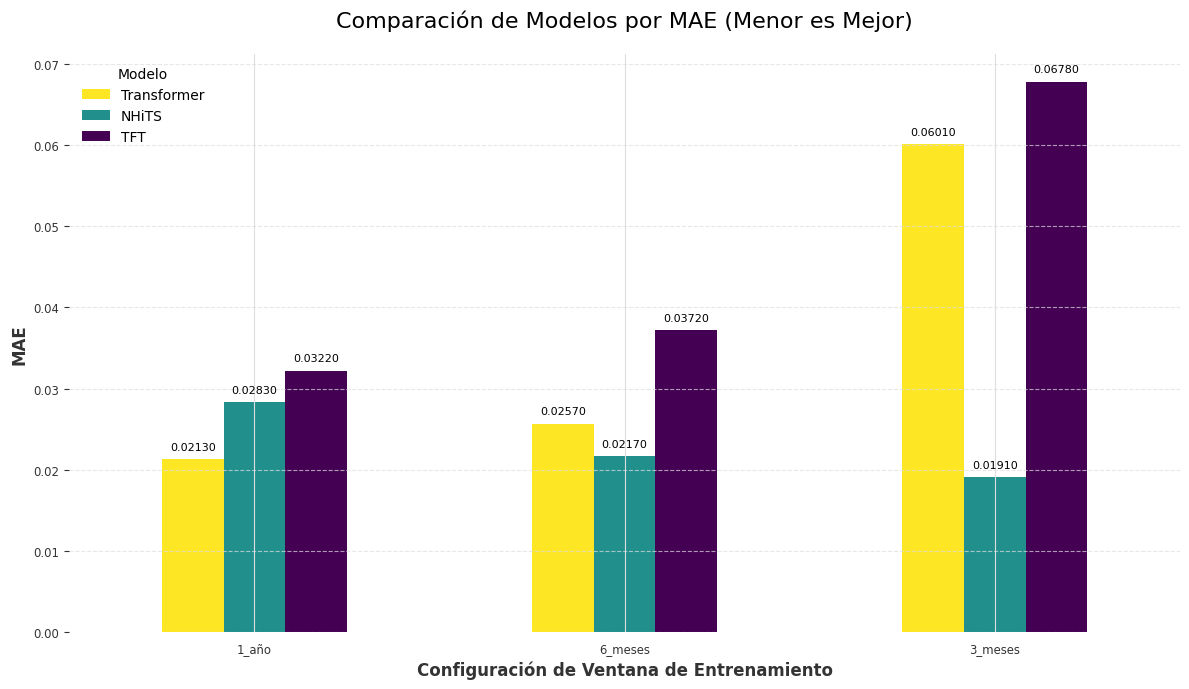

Generando gráfico de barras para MAPE...


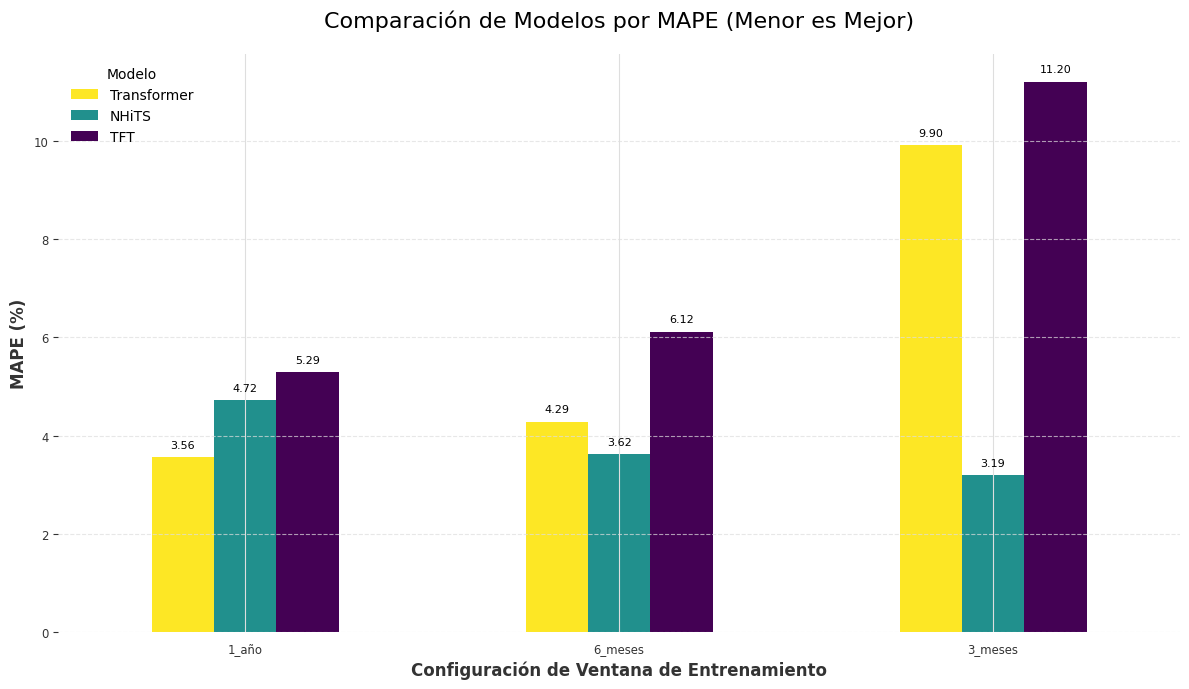

Generando gráfico de barras para RMSE...


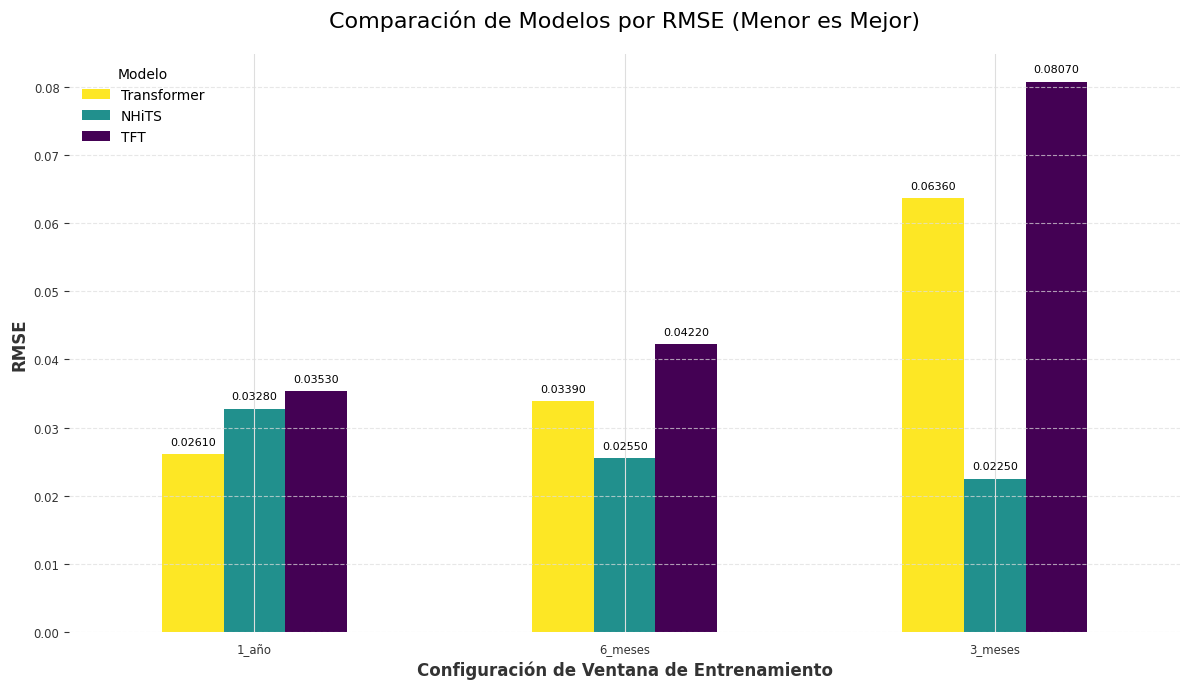


Generando gráfico de barras para Tiempos de Entrenamiento...


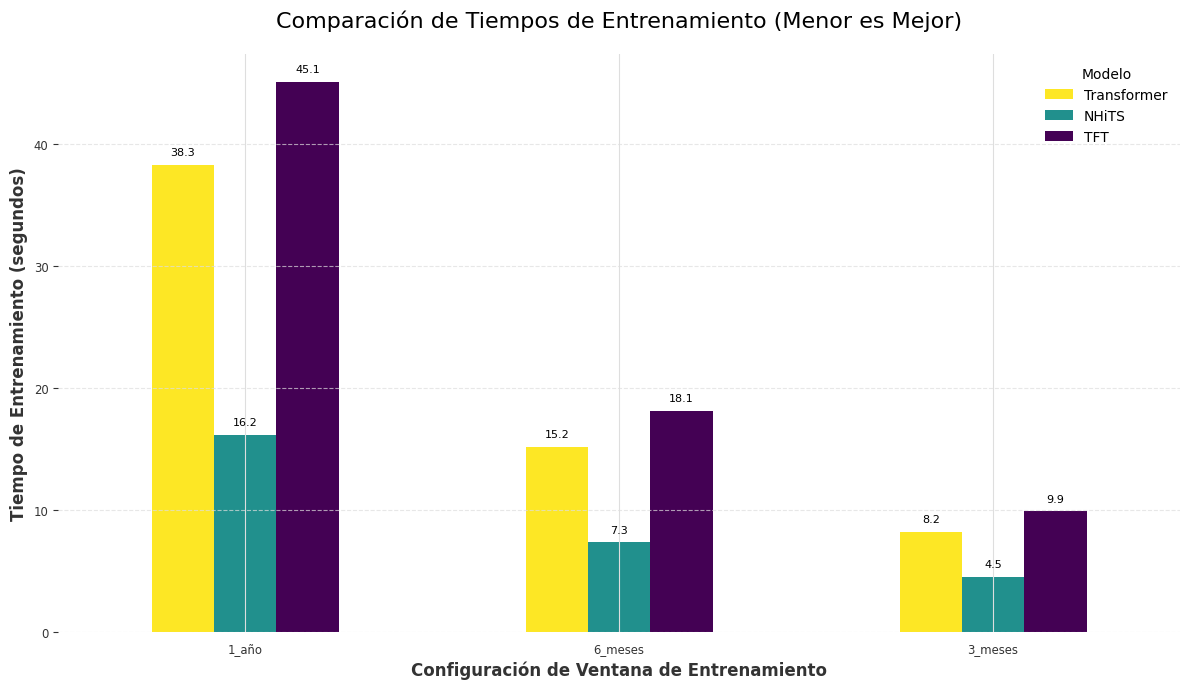


Generando gráfico de barras para Tamaño de Modelos...


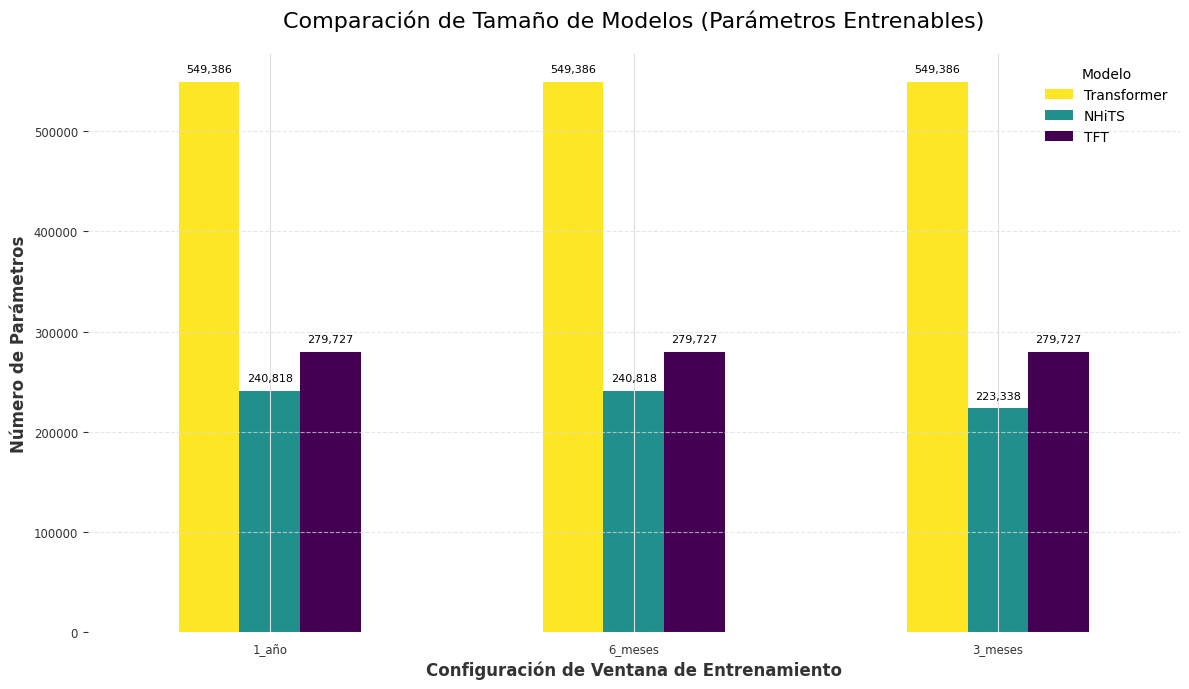

In [26]:
metrics_to_plot = [
    {'name': 'MAE', 'suffix': '', 'format': ".5f", 'lower_is_better': True},
    {'name': 'MAPE', 'suffix': ' (%)', 'format': ".2f", 'lower_is_better': True},
    {'name': 'RMSE', 'suffix': '', 'format': ".5f", 'lower_is_better': True}
]

for metric_info in metrics_to_plot:
    metric_base_name = metric_info['name']
    print(f"Generando gráfico de barras para {metric_base_name}...")
    cols_to_plot = [f'Transformer_{metric_base_name}', f'NHiTS_{metric_base_name}', f'TFT_{metric_base_name}']
    short_names = ['Transformer', 'NHiTS', 'TFT']
    plot_custom_barchart(results_df,
                         cols_to_plot,
                         short_names,
                         title=f'Comparación de Modelos por {metric_base_name} (Menor es Mejor)',
                         y_label=f'{metric_base_name}{metric_info["suffix"]}',
                         lower_is_better=metric_info['lower_is_better'],
                         value_format=metric_info['format'])

print("\nGenerando gráfico de barras para Tiempos de Entrenamiento...")
time_cols = ['Transformer_TrainTime_s', 'NHiTS_TrainTime_s', 'TFT_TrainTime_s']
time_short_names = ['Transformer', 'NHiTS', 'TFT']
plot_custom_barchart(results_df,
                     time_cols,
                     time_short_names,
                     title='Comparación de Tiempos de Entrenamiento (Menor es Mejor)',
                     y_label='Tiempo de Entrenamiento (segundos)',
                     lower_is_better=True, # Menor tiempo es mejor
                     value_format=".1f")   # Un decimal para segundos

print("\nGenerando gráfico de barras para Tamaño de Modelos...")
param_cols = ['Transformer_Params', 'NHiTS_Params', 'TFT_Params']
param_short_names = ['Transformer', 'NHiTS', 'TFT']
plot_custom_barchart(results_df,
                     param_cols,
                     param_short_names,
                     title='Comparación de Tamaño de Modelos (Parámetros Entrenables)',
                     y_label='Número de Parámetros',
                     lower_is_better=True,
                     value_format=",.0f")